In [4]:
import numpy as np
data = np.load('quick_draw_data/aircraft carrier.npy')


116504


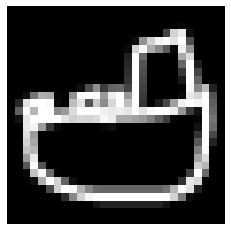

In [5]:
import matplotlib.pyplot as plt

print(len(data))
# Load the first image from the loaded data
image = data[2].reshape(28, 28)

plt.imshow(image, cmap='gray')
plt.axis('off')  # Turn off the axis numbers
plt.show()



In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

# Define a simple neural network model
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()  # Use super() correctly
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# Initialize the model, loss function, and optimizer
model = SimpleNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training loop
for epoch in range(5):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:
            print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f}")
            running_loss = 0.0

print("Finished Training")

# Test the model
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on the test set: {100 * correct / total:.2f}%")




[1, 100] loss: 1.892
[1, 200] loss: 1.185
[1, 300] loss: 0.807
[1, 400] loss: 0.654
[1, 500] loss: 0.540
[1, 600] loss: 0.510
[1, 700] loss: 0.456
[1, 800] loss: 0.435
[1, 900] loss: 0.428
[2, 100] loss: 0.389
[2, 200] loss: 0.389
[2, 300] loss: 0.374
[2, 400] loss: 0.392
[2, 500] loss: 0.364
[2, 600] loss: 0.373
[2, 700] loss: 0.343
[2, 800] loss: 0.350
[2, 900] loss: 0.343
[3, 100] loss: 0.347
[3, 200] loss: 0.320
[3, 300] loss: 0.322
[3, 400] loss: 0.332
[3, 500] loss: 0.333
[3, 600] loss: 0.322
[3, 700] loss: 0.318
[3, 800] loss: 0.298
[3, 900] loss: 0.309
[4, 100] loss: 0.314
[4, 200] loss: 0.295
[4, 300] loss: 0.295
[4, 400] loss: 0.294
[4, 500] loss: 0.298
[4, 600] loss: 0.292
[4, 700] loss: 0.285
[4, 800] loss: 0.293
[4, 900] loss: 0.302
[5, 100] loss: 0.283
[5, 200] loss: 0.277
[5, 300] loss: 0.286
[5, 400] loss: 0.301
[5, 500] loss: 0.286
[5, 600] loss: 0.272
[5, 700] loss: 0.259
[5, 800] loss: 0.276
[5, 900] loss: 0.271
Finished Training
Accuracy on the test set: 92.62%


In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
import torchvision.transforms as transforms

# Load data
data0 = np.load('quick_draw_data/basket.npy')
data1 = np.load('quick_draw_data/arm.npy')
data2 = np.load('quick_draw_data/angel.npy')

def prepare_data(data):
    images = data[:, :-1].astype(float) / 255.0   # Normalize data to [0, 1]
    labels = data[:, -1].astype(int)
    
    if images.shape[1] == 783:
        zeros_column = np.zeros((images.shape[0], 1))
        images = np.hstack((images, zeros_column))

    assert images.shape[1] == 28*28, f"Expected 784 pixels but got {images.shape[1]} pixels."
    
    images = torch.tensor(images, dtype=torch.float32).reshape(-1, 1, 28, 28)  # Adding a channel dimension
    labels = torch.tensor(labels, dtype=torch.int64)
    return TensorDataset(images, labels)

datasets = [prepare_data(d) for d in [data0, data1, data2]]

train_datasets = [random_split(ds, [int(0.8 * len(ds)), len(ds) - int(0.8 * len(ds))])[0] for ds in datasets]
test_datasets = [random_split(ds, [int(0.8 * len(ds)), len(ds) - int(0.8 * len(ds))])[1] for ds in datasets]

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(1152, 128) # Instead of nn.Linear(100352, 128)s
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.max_pool(x)
        x = self.relu(self.conv2(x))
        x = self.max_pool(x)
        x = self.relu(self.conv3(x))
        x = self.max_pool(x)
        x = x.view(-1, 128 * 3 * 3)  # Fixed this line
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


# Initialize the model, loss function, and optimizer
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # Using Adam and L2 regularization

# Data augmentation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
])

# Train the model using data0
train_loader = DataLoader(train_datasets[0], batch_size=64, shuffle=True)
for epoch in range(5):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99:
            print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f}")
            running_loss = 0.0

print("Finished Training")

# Test the model on data1 and data2
for idx, test_dataset in enumerate(test_datasets[1:], 1):
    test_loader = DataLoader(test_dataset, batch_size=64)
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Accuracy on the dataset {idx}: {100 * correct / total:.2f}%")

[1, 100] loss: 0.077
[1, 200] loss: 0.000
[1, 300] loss: 0.000
[1, 400] loss: 0.000
[1, 500] loss: 0.000
[1, 600] loss: 0.000
[1, 700] loss: 0.000
[1, 800] loss: 0.000
[1, 900] loss: 0.000
[1, 1000] loss: 0.000
[1, 1100] loss: 0.000
[1, 1200] loss: 0.000
[1, 1300] loss: 0.000
[1, 1400] loss: 0.000
[2, 100] loss: 0.000
[2, 200] loss: 0.000
[2, 300] loss: 0.000
[2, 400] loss: 0.000
[2, 500] loss: 0.000
[2, 600] loss: 0.000
[2, 700] loss: 0.000
[2, 800] loss: 0.000
[2, 900] loss: 0.000
[2, 1000] loss: 0.000
[2, 1100] loss: 0.000
[2, 1200] loss: 0.000
[2, 1300] loss: 0.000
[2, 1400] loss: 0.000
[3, 100] loss: 0.000
[3, 200] loss: 0.000
[3, 300] loss: 0.000
[3, 400] loss: 0.000
[3, 500] loss: 0.000
[3, 600] loss: 0.000
[3, 700] loss: 0.000
[3, 800] loss: 0.000
[3, 900] loss: 0.000
[3, 1000] loss: 0.000
[3, 1100] loss: 0.000
[3, 1200] loss: 0.000
[3, 1300] loss: 0.000
[3, 1400] loss: 0.000
[4, 100] loss: 0.000
[4, 200] loss: 0.000
[4, 300] loss: 0.000
[4, 400] loss: 0.000
[4, 500] loss: 0.00

In [4]:
# ... (your existing code)

# Print a summary of the model
print("Model Summary:")
print(model)


print("Finished Training")

# Test the model on data1 and data2
for idx, test_dataset in enumerate(test_datasets[1:], 1):
    test_loader = DataLoader(test_dataset, batch_size=64)
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Accuracy on the dataset {idx}: {100 * correct / total:.2f}%")


Model Summary:
CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=1152, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
Finished Training
Accuracy on the dataset 1: 100.00%
Accuracy on the dataset 2: 100.00%
